# 数据读入模块

In [59]:
import pandas as pd


train_data = pd.read_csv("data\main\df_train_b1.csv", index_col=0)
test_data = pd.read_csv('data\main\df_test_b1.csv', index_col=0)


## 要读入除了main之外的数在此处添加

In [60]:
import os
filenames = ["data\detail\df_basic_b1.csv",
             "data\detail\df_corp_b1.csv",
             "data\detail\df_judicial_b1.csv",
             "data\detail\df_loan2_b1.csv",
             "data\detail\df_query_b1.csv"]
for filename in filenames:
    temp = pd.read_csv(filename)
    train_data = pd.merge(train_data, temp, on="cust_id",
                          how="left", suffixes=("", "_y"))
    test_data = pd.merge(test_data, temp, on="cust_id",
                         how="left", suffixes=("", "_y"))


In [61]:
train_data['is_judicial'] = [0 if pd.isna(
    i) else 1 for i in train_data['judicial_reason']]
test_data['is_judicial'] = [0 if pd.isna(
    i) else 1 for i in test_data['judicial_reason']]


In [62]:
train_data['nan_num'] = (train_data == 0).astype(int).sum(axis=1)
test_data['nan_num'] = (test_data == 0).astype(int).sum(axis=1)


In [63]:
import pandas as pd
temp_df = pd.read_csv("./data/detail/df_loan1_b1.csv")


def chuli_loan(df, colname, ways):
    cust_id = list(set(df['cust_id']))
    res_df = pd.DataFrame({'cust_id': cust_id})
    temp_train = pd.read_csv('./data/df_train.csv')
    temp_test = pd.read_csv('./data/df_test.csv')

    ways_1 = []
    temp = list(temp_test.columns)
    global train_data, test_data

    for i in ways:
        if (colname+'_'+i) not in temp:
            ways_1.append(i)
            res_df[colname+'_'+i] = None
        else:
            print(colname+'_'+i+'已存在')
            train_data = pd.merge(train_data, temp_train[['cust_id', colname+'_'+i]], on="cust_id",
                                  how="left", suffixes=("", "_y"))
            test_data = pd.merge(test_data, temp_test[['cust_id', colname+'_'+i]], on="cust_id",
                                 how="left", suffixes=("", "_y"))
    ways = ways_1
    if len(ways) == 0:
        return res_df
    for i in cust_id:
        cust_df = df[df['cust_id'] == i]
        if 'mean' in ways:
            x = cust_df[colname].mean()
            res_df.loc[i, colname+'_mean'] = x
        if 'sum' in ways:
            x = cust_df[colname].sum()
            res_df.loc[i, colname+'_sum'] = x
        if 'count' in ways:
            x = cust_df[colname].count()
            res_df.loc[i, colname+'_count'] = x
    return res_df


for colname in ['loan1_1', 'loan1_3', 'loan1_7', 'loan1_9']:
    df = chuli_loan(temp_df, colname, ('mean', 'sum', 'count'))
    train_data = pd.merge(train_data, df, on="cust_id",
                          how="left", suffixes=("", "_y"))
    test_data = pd.merge(test_data, df, on="cust_id",
                         how="left", suffixes=("", "_y"))

df = chuli_loan(temp_df, 'date_3', ('count',))
train_data = pd.merge(train_data, df, on="cust_id",
                      how="left", suffixes=("", "_y"))
test_data = pd.merge(test_data, df, on="cust_id",
                     how="left", suffixes=("", "_y"))

df = chuli_loan(temp_df, 'loan1_10', ('mean',))
train_data = pd.merge(train_data, df, on="cust_id",
                      how="left", suffixes=("", "_y"))
test_data = pd.merge(test_data, df, on="cust_id",
                     how="left", suffixes=("", "_y"))

df = chuli_loan(temp_df, 'loan1_11', ('sum',))
train_data = pd.merge(train_data, df, on="cust_id",
                      how="left", suffixes=("", "_y"))
test_data = pd.merge(test_data, df, on="cust_id",
                     how="left", suffixes=("", "_y"))

df = chuli_loan(temp_df, 'loan1_12', ('sum',))
train_data = pd.merge(train_data, df, on="cust_id",
                      how="left", suffixes=("", "_y"))
test_data = pd.merge(test_data, df, on="cust_id",
                     how="left", suffixes=("", "_y"))


loan1_1_mean已存在
loan1_1_sum已存在
loan1_1_count已存在
loan1_3_mean已存在
loan1_3_sum已存在
loan1_3_count已存在
loan1_7_mean已存在
loan1_7_sum已存在
loan1_7_count已存在
loan1_9_mean已存在
loan1_9_sum已存在
loan1_9_count已存在
date_3_count已存在
loan1_10_mean已存在
loan1_11_sum已存在
loan1_12_sum已存在


## 处理NAN

In [64]:
def delnan(df):
    df = df.dropna(how="all", axis=1)  # 删除全是空值的列
    df = df.fillna(-99)
    return df


In [65]:
df_train = delnan(train_data)
df_test = delnan(test_data)


## 处理-99

In [66]:
df_train.replace(-99, -1, inplace=True)
df_test.replace(-99, -1, inplace=True)


In [67]:
df_train.to_csv('./data/df_train.csv')
df_test.to_csv('./data/df_test.csv')


## 主成分分析（效果不好）

In [68]:
# from sklearn.decomposition import PCA

# full_col_name = list(df_train.columns)
# pca_col=[i for i in full_col_name if "loan" in i]

# modelPCA=PCA(n_components=0.9)
# temp=modelPCA.fit_transform(df_train[pca_col])
# temp1=modelPCA.transform(df_test[pca_col])
# for i in range(temp.shape[1]):
#     df_train['loan_pca'+str(i)]=temp[:,i]
#     df_test['loan_pca'+str(i)]=temp1[:,i]


## 处理分类变量

In [69]:
type_col = ["basic_1",
            "basic_10",
            "basic_12",
            "basic_14",
            "loan1_16",
            "loan1_20",
            "loan1_23",
            "loan1_25", ]


## 转化为one-hot编码（不宜采用）

In [70]:

def to_one_hot(df, colnames):
    df = pd.get_dummies(df, columns=colnames)
    return df


""" df_train = to_one_hot(df_train, type_col)
df_test = to_one_hot(df_test, type_col)
for i in df_train.columns:
    if i not in df_test.columns:
        df_test[i] = 0
 """


' df_train = to_one_hot(df_train, type_col)\ndf_test = to_one_hot(df_test, type_col)\nfor i in df_train.columns:\n    if i not in df_test.columns:\n        df_test[i] = 0\n '

## 证据权重

In [71]:
import pandas as pd
import numpy as np


def cal_woe(df, df_no_label, x_cols, y_col):
    for i in x_cols:
        x_set = pd.unique(df[i])
        for j in x_set:
            woe = np.mean(df[df[i] == j][y_col])
            df[i].replace(j, woe, inplace=True)
            df_no_label[i].replace(j, woe, inplace=True)
    return df, df_no_label


In [72]:
df_train, df_test = cal_woe(df_train, df_test, type_col, "label")


In [73]:
full_col_name = list(df_train.columns)
basic_col = [i for i in full_col_name if "basic" in i]
loan_col = [i for i in full_col_name if "loan" in i]
overdue_col = [i for i in full_col_name if "overdue" in i]
query_col = [i for i in full_col_name if "query" in i]
judicial_col = [i for i in full_col_name if "judicial" in i]
loan_pca_col = [i for i in full_col_name if "loan_pca" in i]

""" for i in judicial_col:
    df_train[i].astype("float")
    df_test[i].astype("float") """


' for i in judicial_col:\n    df_train[i].astype("float")\n    df_test[i].astype("float") '

## rank化

In [74]:
def rank(rank_col):
    global df_train, df_test
    df1 = df_train[['cust_id']+rank_col]
    df2 = df_test[['cust_id']+rank_col]
    df = pd.concat([df1, df2], axis=0, ignore_index=True)
    for i in rank_col:
        df[i] = np.argsort(df[i])
        del df_test[i]
        del df_train[i]
    df_train = pd.merge(df_train, df, on="cust_id",
                        how="left", suffixes=("", "_y"))
    df_test = pd.merge(df_test, df, on="cust_id",
                       how="left", suffixes=("", "_y"))


a = ['loan1_1', 'loan1_3', 'loan1_7', 'loan1_9']
b = ['_sum', '_mean']
c = []
for i in a:
    for j in b:
        c.append(i+j)
# rank(c)


## 归一化

In [75]:
def norm(rank_col):
    global df_train, df_test
    df1 = df_train[['cust_id']+rank_col]
    df2 = df_test[['cust_id']+rank_col]
    df = pd.concat([df1, df2], axis=0, ignore_index=True)
    for i in rank_col:
        df[i] = (df[i]-np.min(df[i]))/(np.max(df[i])-np.min(df[i]))
        del df_test[i]
        del df_train[i]
    df_train = pd.merge(df_train, df, on="cust_id",
                        how="left", suffixes=("", "_y"))
    df_test = pd.merge(df_test, df, on="cust_id",
                       how="left", suffixes=("", "_y"))


a = ['loan1_1', 'loan1_3', 'loan1_7', 'loan1_9']
b = ['_sum', '_mean']
c = []
for i in a:
    for j in b:
        c.append(i+j)
norm(c)


## 标准化

In [76]:
def stand(rank_col):
    global df_train, df_test
    df1 = df_train[['cust_id']+rank_col]
    df2 = df_test[['cust_id']+rank_col]
    df = pd.concat([df1, df2], axis=0, ignore_index=True)
    for i in rank_col:
        df[i] = (df[i]-np.mean(df[i],axis=0))/np.std(df[i],axis=0)
        del df_test[i]
        del df_train[i]
    df_train = pd.merge(df_train, df, on="cust_id",
                        how="left", suffixes=("", "_y"))
    df_test = pd.merge(df_test, df, on="cust_id",
                       how="left", suffixes=("", "_y"))


a = ['loan1_1', 'loan1_3', 'loan1_7', 'loan1_9']
b = ['_sum', '_mean']
c = []
for i in a:
    for j in b:
        c.append(i+j)
#stand(c)


## 设置哪些x作为模型自变量输入

In [77]:
x_col = basic_col+['is_judicial']+loan_col+['date_3_count']+query_col


In [78]:
# df_train.drop(columns=drop_col)


# 训练模型

## 超参数

In [79]:
N = 100
num_round = 100
local_test_size = 3000

max_depth = [3, 4, 5, 6, 7, 8]
eta = [0.1, 0.06]
colsample_bytree = [0.8, 0.7, 0.6]
scale_pos_weight = [1, 3, 6, 10, 20, 30]
test_size = [0.3, 0.2, 0.4, 0.5, 0.6, 0.7]
subsample = [0.8, 0.7, 0.6, 0.5, 0.4]
par_lambda = [1, 1.5, 2, 3]
alpha = [0, 0.2, 0.4, 0.6, 0.8]
min_child_weight = [1, 2, 3, 4, 5]


### train划分为
* 本地测试集（固定）d_localtest
* 训练集（固定）
  * 评估集（每次的模型不同）dtest
  * 真正的训练集（每次的模型不同）dtrain

In [80]:
import copy
import xgboost as xgb
import random
from sklearn import model_selection
from sklearn.metrics import roc_auc_score


pred_labels = []
local_test_labels = []
loss_seq = []
max_auc_loss = 0
flag = 0
important_x_seq = []

num_seq = list(range(len(df_train)))
np.random.shuffle(num_seq)

X_local_test = df_train[x_col].iloc[num_seq[0:local_test_size]]
Y_local_test = df_train["label"].iloc[num_seq[0:local_test_size]]

d_localtest = xgb.DMatrix(X_local_test, label=Y_local_test)

X = df_train[x_col].iloc[num_seq[local_test_size:len(df_train)]]
Y = df_train['label'].iloc[num_seq[local_test_size:len(df_train)]]
x_perd = xgb.DMatrix(df_test[x_col])

for i in range(N):

    #seed = 666
    test_size_this_round = random.choice(test_size)
    X_train, X_test, y_train, y_test = model_selection.train_test_split(
        X, Y, test_size=test_size_this_round)
    # seed+=1

    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)
    evallist = [(dtest, 'eval')]

    param = {
        'max_depth': random.choice(max_depth),
        'eta': random.choice(eta),
        'colsample_bytree': random.choice(colsample_bytree),
        'objective': 'binary:logistic',
        # 'verbosity':0,
        'scale_pos_weight': random.choice(scale_pos_weight),
        'eval_metric': 'auc',
        'subsample': random.choice(subsample),
        'alpha': random.choice(alpha),
        'lambda': random.choice(par_lambda),
        'min_child_weight': random.choice(min_child_weight),
        # 'seed': 666,
        'tree_method': 'gpu_hist',
        'gpu_id': 0,
        # "enable_enable_categorical":True,
    }

    bst = xgb.train(param, dtrain, num_round, evals=evallist,
                    early_stopping_rounds=5, verbose_eval=False)

    loss = float(bst.eval(dtest).split(":")[1])
    train_loss = float(bst.eval(dtrain).split(":")[1])
    local_test_loss = float(bst.eval(d_localtest).split(":")[1])

    pred_label = list(bst.predict(x_perd))
    test_label = list(bst.predict(xgb.DMatrix(X_local_test)))
    # temp=roc_auc_score(y_test,test_label)
    # print(test_label[0:10])

    temp_dict = {"test_auc": loss, "train_auc": train_loss,
                 'local_test_auc': local_test_loss, 'test_size': test_size_this_round}
    temp_dict.update(param)

    # info_df=info_df.append(pd.DataFrame(temp_dict))
    if flag == 0:
        info_df = pd.DataFrame(temp_dict, index=[i])
        flag = 1
    else:
        info_df = pd.concat([info_df, pd.DataFrame(temp_dict, index=[i])])

    if loss > max_auc_loss:
        best_bst = copy.deepcopy(bst)
        max_auc_loss = loss

    if False:
        pic = xgb.plot_importance(bst, max_num_features=50)
        temp = pic.get_ymajorticklabels()
        important_x = [str(i).split("\'")[1] for i in temp]
        important_x.reverse()
        important_x_seq += important_x

    print(i+1, ":", loss, sep="")
    # print(param)
    # print("-------------------------")
    pred_labels.append([j for j in pred_label])
    local_test_labels.append(copy.deepcopy(test_label))


print('最大AUC:', max(info_df['local_test_auc']), sep="")


1:0.6802506583509444
2:0.6913760304375396
3:0.6350114678899083
4:0.6758008247031043
5:0.6873825140408373
6:0.6947861172627041
7:0.7232216640316329
8:0.6424680983504513
9:0.6615317520362703
10:0.7174856393606394
11:0.6408580855866458
12:0.6954623556173943
13:0.6591418622742631
14:0.7032249290757369
15:0.6907474317394084
16:0.6312856721868484
17:0.635652197113204
18:0.6674288588117914
19:0.7035394823066842
20:0.6583458552792351
21:0.683370741252302
22:0.6677520430703164
23:0.6880087481970983
24:0.7096984620849115
25:0.6505635380127583
26:0.5
27:0.706663026518854
28:0.6682013665163642
29:0.6541132153625524
30:0.6551329225745486
31:0.695176347826087
32:0.6753694513983995
33:0.7171957458110558
34:0.6958479603484339
35:0.6637263797493528
36:0.6711607128649558
37:0.6244434926453227
38:0.708350789608374
39:0.6165073426567962
40:0.6795567659636634
41:0.6997644142661423
42:0.6554491331689043
43:0.6622701929976131
44:0.6671172832494504
45:0.671764634079995
46:0.6684482194536552
47:0.6503098833977

In [81]:
info_df


,test_auc,train_auc,local_test_auc,test_size,max_depth,eta,colsample_bytree,objective,scale_pos_weight,eval_metric,subsample,alpha,lambda,min_child_weight,tree_method,gpu_id
0,0.680251,0.832712,0.706636,0.5,3,0.06,0.8,binary:logistic,6,auc,0.6,0.2,1.0,4,gpu_hist,0
1,0.691376,0.770719,0.622813,0.4,4,0.06,0.6,binary:logistic,1,auc,0.6,0.2,1.5,1,gpu_hist,0
2,0.635011,0.932260,0.692102,0.3,7,0.10,0.7,binary:logistic,6,auc,0.4,0.6,1.5,3,gpu_hist,0
3,0.675801,0.883343,0.708308,0.6,4,0.06,0.6,binary:logistic,6,auc,0.6,0.8,1.5,2,gpu_hist,0
4,0.687383,0.924171,0.688043,0.5,4,0.10,0.7,binary:logistic,20,auc,0.6,0.0,3.0,1,gpu_hist,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.668256,0.867880,0.692668,0.7,3,0.06,0.8,binary:logistic,30,auc,0.5,0.4,1.0,4,gpu_hist,0
96,0.684672,0.961130,0.640796,0.4,7,0.10,0.8,binary:logistic,6,auc,0.5,0.0,2.0,4,gpu_hist,0
97,0.701619,0.991943,0.690850,0.6,6,0.10,0.6,binary:logistic,10,auc,0.6,0.8,2.0,5,gpu_hist,0
98,0.664150,0.945281,0.697479,0.7,5,0.06,0.8,binary:logistic,30,auc,0.4,0.2,1.0,5,gpu_hist,0


In [82]:
info_df.to_csv("info.csv", encoding="utf-8", index=False)


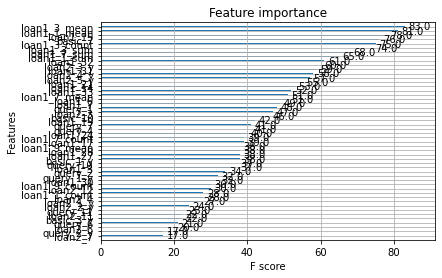

In [83]:
pic = xgb.plot_importance(best_bst, max_num_features=50)
temp = pic.get_ymajorticklabels()
important_x = [str(i).split("\'")[1] for i in temp]
important_x.reverse()


In [84]:
important_x


['loan1_3_mean',
 'loan1_1_mean',
 'loan1_15',
 'basic_7',
 'loan1_3_count',
 'loan1_3_sum',
 'loan1_7_sum',
 'loan1_1_sum',
 'loan1_32',
 'loan2_3_y',
 'loan1_31',
 'loan2_4_y',
 'loan2_5_y',
 'loan1_21',
 'loan1_14',
 'loan1_33',
 'loan1_7_mean',
 'loan1_6',
 'loan1_7',
 'query_1',
 'loan2_3',
 'basic_10',
 'loan1_19',
 'query_7',
 'query_4',
 'loan1_24',
 'loan1_7_count',
 'loan1_17',
 'loan1_9_mean',
 'loan1_28',
 'loan1_27',
 'basic_1_y',
 'query_10',
 'loan1_3',
 'query_2',
 'query_1_y',
 'loan1_30',
 'loan1_9_count',
 'loan2_12',
 'loan1_1_count',
 'loan2_4',
 'loan2_1_y',
 'loan2_2_y',
 'query_11',
 'loan2_11',
 'basic_3_y',
 'query_6',
 'loan2_6',
 'query_2_y',
 'loan2_7']

In [85]:
# pd.value_counts(important_x_seq)


* basic_7:年龄
* 

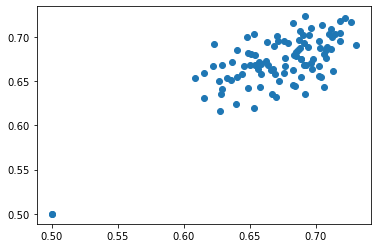

In [86]:
import matplotlib.pyplot as plt
plt.scatter(info_df['local_test_auc'], info_df['test_auc'])


# 输出模块

In [91]:
import time
import numpy as np
from sklearn.metrics import roc_auc_score

date = time.strftime("%Y%m%d-%H%M%S", time.localtime())
res_num = np.argsort([-i for i in info_df['local_test_auc']])

# 选择前n个结果进行平均（手动指定or在本地测试集排序选出）
if True:
    max_auc = -1
    list_temp = []
    for i in range(N):
        list_temp.append(local_test_labels[res_num[i]])
        # 算数平均
        # temp = np.mean(list_temp, axis=0)
        # 几何平均(better)
        temp=np.exp(np.mean(np.log(list_temp),axis=0))
        temp_auc = roc_auc_score(Y_local_test, temp)
        print(i, temp_auc)
        if temp_auc > max_auc:
            max_auc = temp_auc
            n = i+1
else:
    n = 100
    n = min(N, n)

res_num = res_num[0:n]

#final_pred_label = np.mean([pred_labels[i] for i in res_num], axis=0)
final_pred_label = np.exp(np.mean(np.log([pred_labels[i] for i in res_num]),axis=0))
#local_auc = roc_auc_score(y_test, final_pred_label)
print("本地测试集前", n, "个auc为", [
      list(info_df['local_test_auc'])[i] for i in res_num], sep="")
print("平均之后AUC为", max_auc, sep="")

res = pd.DataFrame({
    'cust_id': list(df_test["cust_id"]),
    'label': final_pred_label,
})
res.to_csv("./output/result"+date+".csv", encoding="utf-8", index=False)


0 0.7308070066750025
1 0.7461685787570971
2 0.759019941900657
3 0.7575882350719063
4 0.7557712140042838
5 0.7571613673366854
6 0.7555596689319619
7 0.7606027523524945
8 0.7610579520170445
9 0.7598019031501327
10 0.7586384052523619
11 0.7581662064302147
12 0.7588877262304559
13 0.7596470219364685
14 0.7600738896716894
15 0.7599227860486026
16 0.7613318273338898
17 0.7610182873159841
18 0.762967524053808
19 0.7629750792349624
20 0.761418711917165
21 0.7606103075336489
22 0.759937896410911
23 0.7610069545442526
24 0.7613431601056214
25 0.7597754600160925
26 0.7594845855416498
27 0.7589934987666168
28 0.7579546613578926
29 0.7580528787128994
30 0.7585817413937043
31 0.7580453235317449
32 0.7579319958144296
33 0.7579093302709665
34 0.7572482519199605
35 0.7571387017932223
36 0.7570971482968732
37 0.7568478273187795
38 0.7565342873008736
39 0.755861876178136
40 0.7556352207435053
41 0.7549552544396133
42 0.7550005855265394
43 0.7548117059976805
44 0.7547097110520968
45 0.7541921811430233
46 

In [89]:
np.log(list_temp)

array([[-1.0171031 , -1.3081374 , -0.8592709 , ..., -1.2951013 ,
        -1.0314959 , -1.0050899 ],
       [-2.8229916 , -3.4440694 , -2.7518334 , ..., -3.200905  ,
        -3.5584512 , -2.8313446 ],
       [-1.441002  , -1.3287266 , -0.8058003 , ..., -0.63730586,
        -0.5526225 , -0.68558174],
       ...,
       [-1.9105706 , -2.358278  , -1.9872473 , ..., -2.223251  ,
        -2.8321412 , -1.5773804 ],
       [-1.0290556 , -1.0290556 , -1.0290556 , ..., -1.0290556 ,
        -1.0290556 , -1.0290556 ],
       [-1.0322969 , -1.0322969 , -1.0322969 , ..., -1.0322969 ,
        -1.0322969 , -1.0322969 ]], dtype=float32)

# 一些tips

* 提升n有一定提升(如何确定n？)
  * n=40 0.6763
  * n=10 0.6728
  * n=100 0.6774
  * 太大也不好

# 一些进展

* 随机参数
* XGB模型
* 本地测试集auc较高（0.75+）
* 部分类型变量进行了one-hot处理
* 把细分表除了loan与主表合并

# tbd

* 处理细分表的loan，给出指标
* 确定变量类型，以便对所有（or重要）分类变量进行one-hot处理
* 新模型？

## 10-12
* 0.6824（这次我留了代码\doge）
* 把-99变为-1，本地有提升
* 划出了一个本地测试集
  * 本地测试集（固定）d_localtest
  * 训练集（固定）
    * 评估集（每次的模型不同）dtest
    * 真正的训练集（每次的模型不同）dtrain
* 添加参数nan_num（然并卵）
* tbd
  * 找特征
  * 加x
  * 分析一下参数作用